<h1>Make Spatial Mask Based on Tides for Shoreline</h1>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cftime
import datetime
import matplotlib as mpl
%matplotlib widget

Text(0, 0.5, 'Water Level Relative to NAVD88, [m]')

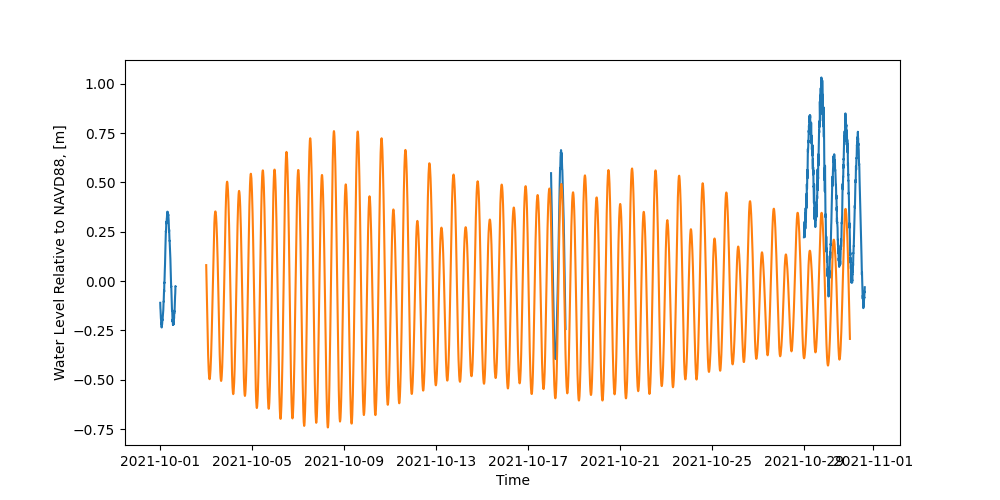

In [19]:
# Import Tide Data from FRF data portal
tide_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterlevel/eopNoaaTide/2021/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
tide_dataset = nc.Dataset(tide_url)

# Get Varaibles from the Tide Data
tide_time = cftime.num2pydate(tide_dataset.variables['time'][:], units=tide_dataset.variables['time'].units, calendar=tide_dataset.variables['time'].calendar)
# NOTE: Water level is referenced to the NAVD88 datum 
water_level = tide_dataset['waterLevel'][:] # Units are meters
water_level_predicted = tide_dataset['predictedWaterLevel']

# Find tides during experiment
experiment_start = datetime.datetime(2021, 10, 3, 0, 0, 0)
experiment_end = datetime.datetime(2021, 10, 31, 0, 0, 0)

# Sort Indices within experiment
indices_in_experiment = []
tide_time_inex = []
for ind in np.arange(len(tide_time)):
    if (tide_time[ind] >= experiment_start) & (tide_time[ind] <= experiment_end):
        indices_in_experiment.append(int(ind))
        tide_time_inex.append(tide_time[ind])
    else:
        continue

# Sort Water level to be within the experiment
water_level_inex = water_level[indices_in_experiment]
water_level_predicted_inex = water_level_predicted[indices_in_experiment]

# Plot Water Level time Series
fig_waterlevel, ax = plt.subplots(figsize=(10,5))
ax.plot(tide_time, water_level)
ax.plot(tide_time_inex, water_level_predicted_inex)
ax.set_xlabel('Time')
ax.set_ylabel('Water Level Relative to NAVD88, [m]')

Well it looks like a bunch of data is missing from tidal information. We can maybe find another data source to get water levels. For now, we are just going to move on with this notebook and try to figure out a good way to build a mask.

Text(0, 0.5, 'Elevation relative to NAVD88 [m]')

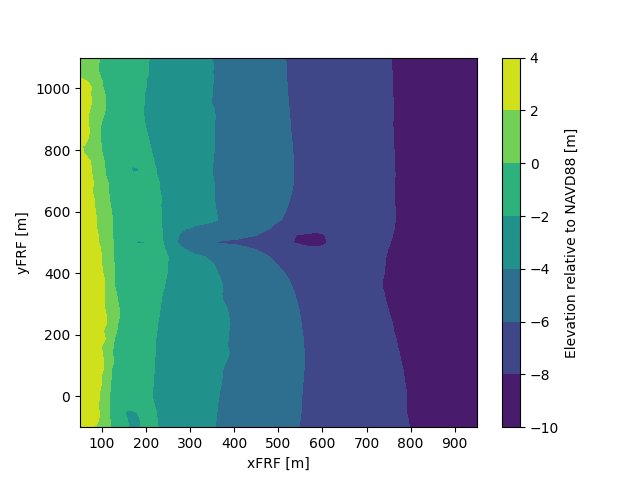

In [27]:
# Import bathymetry data from FRF data portal 
bathy_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/surveyDEM/data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_url)

# Get Values from bathymetry dataset
bathy_time = bathy_dataset['time'][:]
xFRF = bathy_dataset['xFRF'][:]
yFRF = bathy_dataset['yFRF'][:]
elevation = bathy_dataset['elevation'][0, :, :]

# Create Meshgrid from x and y vectors
xFRF_grid, yFRF_grid = np.meshgrid(xFRF, yFRF)

# Plot bathymetry data
fig_bathy, ax = plt.subplots()
map = ax.contourf(xFRF_grid, yFRF_grid, elevation)
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')
cbar = plt.colorbar(map, ax=ax)
cbar.ax.set_ylabel('Elevation relative to NAVD88 [m]')

In [88]:
# Create Mask by setting all positive values to 0 and negative values to 1 
tidal_mask = np.ones((len(water_level_predicted_inex), elevation.shape[0], elevation.shape[1]))

# Generate mask from positive and negative values of bathymetery corrected by tidal height
for water_level_ind in np.arange(len(water_level_predicted)):
    elevation_tidal_corrected = elevation + water_level_predicted[water_level_ind]
    indices_out_of_water = np.nonzero(elevation_tidal_corrected > 0)
    tidal_mask[water_level_ind, indices_out_of_water[0], indices_out_of_water[1]] = 0

# Plot Tidal mask 
fig_mask, ax = plt.subplots()

# define the colors
cmap = mpl.colors.ListedColormap(['y', 'b'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

map = ax.pcolor(xFRF, yFRF, tidal_mask[0, :, :], cmap=cmap, norm=norm, shading='auto')
cbar = plt.colorbar(map, ax=ax)
cbar.ax.set_ylabel('Mask Value')
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')


(6721, 51, 76)
